<a href="https://colab.research.google.com/github/spouladchang/Mountain-Car-RL-Optimization/blob/main/2_MountainCar_DQN_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MountainCar-v0 Deep Q-Network (DQN) Implementation

This notebook implements a **Deep Q-Network (DQN)** agent using PyTorch to solve the MountainCar-v0 environment. Unlike tabular Q-Learning, DQN uses a neural network to approximate the Q-function, enabling it to handle continuous state spaces without discretization.

## Key Advantages of DQN:
- No manual state discretization needed
- Experience replay for sample efficiency
- Target network for training stability
- Scales to high-dimensional problems

## 1. Import Libraries

In [1]:
import numpy as np
import gymnasium as gym
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, display
import time
import os

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

Using device: cpu


## 2. Configuration & Hyperparameters

### Network Architecture
- **Input**: 2 features (position, velocity)
- **Hidden**: 256 → 256 neurons with ReLU activation
- **Output**: 3 Q-values (one per action)

### Hyperparameters (Optimized for MountainCar)

These values were tuned through experimentation:

- **Learning Rate**: 0.001 (Adam optimizer)
  - Stable learning without overshooting
  
- **Epsilon Schedule**: 1.0 → 0.01
  - Slow decay (0.995) crucial for sparse rewards
  - Ensures sustained exploration
  
- **Replay Buffer**: 50,000 transitions
  - Large buffer improves sample diversity
  
- **Batch Size**: 64
  - Good balance of stability and speed
  
- **Target Network Update**: Every 10 episodes
  - Frequent updates for faster convergence
  
- **Episodes**: 2000
  - DQN converges faster than Q-Learning!

In [2]:
# Hyperparameters
LEARNING_RATE = 0.001
GAMMA = 0.99
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.995
REPLAY_BUFFER_SIZE = 50000
BATCH_SIZE = 64
TARGET_UPDATE_FREQUENCY = 10
EPISODES = 2000

# Network architecture
HIDDEN_SIZE = 256

## 3. Neural Network Architecture

A simple but effective feedforward network for Q-value approximation.

In [3]:
class DQNetwork(nn.Module):
    """Deep Q-Network for MountainCar."""

    def __init__(self, state_dim, action_dim, hidden_size=256):
        super(DQNetwork, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(state_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_dim)
        )

    def forward(self, x):
        return self.network(x)

## 4. DQN Agent

### Key Components:

1. **Experience Replay**: Stores transitions for mini-batch learning
2. **Target Network**: Stabilizes training by fixing Q-targets
3. **Epsilon-Greedy**: Balances exploration vs exploitation

In [4]:
class DQNAgent:
    """DQN Agent with experience replay and target network."""

    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim

        # Networks
        self.policy_net = DQNetwork(state_dim, action_dim, HIDDEN_SIZE).to(device)
        self.target_net = DQNetwork(state_dim, action_dim, HIDDEN_SIZE).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        # Optimizer
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=LEARNING_RATE)

        # Experience replay
        self.memory = deque(maxlen=REPLAY_BUFFER_SIZE)

        # Exploration
        self.epsilon = EPSILON_START

    def act(self, state, training=True):
        """Select action using epsilon-greedy policy."""
        if training and random.random() < self.epsilon:
            return random.randrange(self.action_dim)

        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            q_values = self.policy_net(state_tensor)
            return q_values.argmax().item()

    def remember(self, state, action, reward, next_state, done):
        """Store transition in replay buffer."""
        self.memory.append((state, action, reward, next_state, done))

    def replay(self):
            """Train on a mini-batch from replay buffer."""
            if len(self.memory) < BATCH_SIZE:
                return None

            # Sample mini-batch
            batch = random.sample(self.memory, BATCH_SIZE)

            # Unpack batch - FIXED: Convert to numpy first (removes warning)
            states = torch.FloatTensor(np.array([t[0] for t in batch])).to(device)
            actions = torch.LongTensor(np.array([t[1] for t in batch])).unsqueeze(1).to(device)
            rewards = torch.FloatTensor(np.array([t[2] for t in batch])).to(device)
            next_states = torch.FloatTensor(np.array([t[3] for t in batch])).to(device)
            dones = torch.FloatTensor(np.array([t[4] for t in batch])).to(device)

            # Compute current Q-values
            current_q_values = self.policy_net(states).gather(1, actions).squeeze()

            # Compute target Q-values
            with torch.no_grad():
                next_q_values = self.target_net(next_states).max(1)[0]
                target_q_values = rewards + (GAMMA * next_q_values * (1 - dones))

            # Compute loss
            loss = nn.MSELoss()(current_q_values, target_q_values)

            # Optimize
            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 1.0)
            self.optimizer.step()

            return loss.item()

    def update_epsilon(self):
        """Decay epsilon."""
        self.epsilon = max(EPSILON_END, self.epsilon * EPSILON_DECAY)

    def update_target_network(self):
        """Copy weights from policy network to target network."""
        self.target_net.load_state_dict(self.policy_net.state_dict())

## 5. Training Function

Trains the DQN agent while tracking comprehensive metrics.

In [5]:
def train_dqn(env, agent, episodes=EPISODES):
    """Train DQN agent and track metrics."""

    # Metrics
    rewards_history = []
    max_positions_history = []
    losses_history = []
    epsilon_history = []

    print("="*70)
    print("DQN TRAINING STARTED")
    print("="*70)
    print(f"Episodes: {episodes}")
    print(f"Replay Buffer Size: {REPLAY_BUFFER_SIZE}")
    print(f"Batch Size: {BATCH_SIZE}")
    print(f"Learning Rate: {LEARNING_RATE}")
    print("="*70)
    print()

    start_time = time.time()
    best_avg_reward = -float('inf')

    for episode in range(episodes):
        state, _ = env.reset()
        episode_reward = 0
        max_position = state[0]
        episode_losses = []
        done = False

        while not done:
            # Select and perform action
            action = agent.act(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Store transition
            agent.remember(state, action, reward, next_state, done)

            # Train
            loss = agent.replay()
            if loss is not None:
                episode_losses.append(loss)

            # Update state and metrics
            state = next_state
            episode_reward += reward
            max_position = max(max_position, next_state[0])

        # Update epsilon
        agent.update_epsilon()

        # Update target network
        if (episode + 1) % TARGET_UPDATE_FREQUENCY == 0:
            agent.update_target_network()

        # Store metrics
        rewards_history.append(episode_reward)
        max_positions_history.append(max_position)
        epsilon_history.append(agent.epsilon)

        if episode_losses:
            losses_history.append(np.mean(episode_losses))
        else:
            losses_history.append(0)

        # Progress logging
        if (episode + 1) % 200 == 0:
            avg_reward = np.mean(rewards_history[-100:])
            avg_position = np.mean(max_positions_history[-100:])
            avg_loss = np.mean(losses_history[-100:]) if losses_history else 0

            print(f"Episode {episode+1:4d} | "
                  f"Avg Reward: {avg_reward:6.1f} | "
                  f"Avg Max Pos: {avg_position:+.2f} | "
                  f"Loss: {avg_loss:.4f} | "
                  f"ε: {agent.epsilon:.3f}")

        # Save checkpoints at specific episodes for showcase GIFs
        if (episode + 1) in [500, 1000, 2000]:
            checkpoint_path = f'checkpoint_ep{episode+1}.pth'
            torch.save({
                'model_state_dict': agent.policy_net.state_dict(),
                'episode': episode + 1,
                'avg_reward': np.mean(rewards_history[-100:]) if episode >= 100 else -200,
                'epsilon': agent.epsilon
            }, checkpoint_path)
            print(f"💾 Saved checkpoint: {checkpoint_path}")

    training_time = time.time() - start_time

    print()
    print("="*70)
    print("TRAINING COMPLETED")
    print("="*70)
    print(f"Total Time: {training_time:.2f}s")
    print(f"Time per Episode: {training_time/episodes:.3f}s")
    print("="*70)

    return {
        'rewards': rewards_history,
        'positions': max_positions_history,
        'losses': losses_history,
        'epsilon': epsilon_history
    }

## 6. Run Training

In [6]:
# Create environment and agent
env = gym.make('MountainCar-v0')
agent = DQNAgent(state_dim=2, action_dim=3)

# Train
metrics = train_dqn(env, agent, episodes=EPISODES)

env.close()

DQN TRAINING STARTED
Episodes: 2000
Replay Buffer Size: 50000
Batch Size: 64
Learning Rate: 0.001

Episode  200 | Avg Reward: -200.0 | Avg Max Pos: -0.36 | Loss: 0.8735 | ε: 0.367
Episode  400 | Avg Reward: -200.0 | Avg Max Pos: -0.26 | Loss: 3.5294 | ε: 0.135
💾 Saved checkpoint: checkpoint_ep500.pth
Episode  600 | Avg Reward: -181.1 | Avg Max Pos: +0.31 | Loss: 5.1791 | ε: 0.049
Episode  800 | Avg Reward: -148.8 | Avg Max Pos: +0.50 | Loss: 2.3394 | ε: 0.018
Episode 1000 | Avg Reward: -128.4 | Avg Max Pos: +0.52 | Loss: 0.5606 | ε: 0.010
💾 Saved checkpoint: checkpoint_ep1000.pth
Episode 1200 | Avg Reward: -125.2 | Avg Max Pos: +0.52 | Loss: 0.3211 | ε: 0.010
Episode 1400 | Avg Reward: -103.5 | Avg Max Pos: +0.51 | Loss: 0.1464 | ε: 0.010
Episode 1600 | Avg Reward: -101.9 | Avg Max Pos: +0.51 | Loss: 0.1352 | ε: 0.010
Episode 1800 | Avg Reward: -100.2 | Avg Max Pos: +0.51 | Loss: 0.0515 | ε: 0.010
Episode 2000 | Avg Reward: -100.5 | Avg Max Pos: +0.51 | Loss: 0.0309 | ε: 0.010
💾 Saved 

## 7. Performance Evaluation

In [7]:
def test_dqn_agent(agent, num_episodes=100):
    """Test trained DQN agent."""
    test_env = gym.make('MountainCar-v0')

    # Load best model
    if os.path.exists('trained_weights_dqn.pth'):
        checkpoint = torch.load('trained_weights_dqn.pth', map_location=device, weights_only=False)
        agent.policy_net.load_state_dict(checkpoint['model_state_dict'])
        agent.policy_net.eval()
        print("✅ Loaded trained model")

    successes = 0
    total_rewards = []
    successful_steps = []

    for ep in range(num_episodes):
        state, _ = test_env.reset()
        episode_reward = 0
        steps = 0
        done = False

        while not done and steps < 200:
            action = agent.act(state, training=False)
            next_state, reward, terminated, truncated, _ = test_env.step(action)

            state = next_state
            episode_reward += reward
            steps += 1
            done = terminated or truncated

        total_rewards.append(episode_reward)

        if next_state[0] >= 0.5:
            successes += 1
            successful_steps.append(steps)
            if ep < 10:
                print(f"  Test {ep+1:2d}: ✅ SUCCESS | Reward: {episode_reward:6.1f} | Steps: {steps:3d}")
        elif ep < 10:
            print(f"  Test {ep+1:2d}: ❌ FAILED  | Reward: {episode_reward:6.1f} | Steps: {steps:3d}")

    test_env.close()

    success_rate = (successes / num_episodes) * 100
    avg_reward = np.mean(total_rewards)
    avg_steps = np.mean(successful_steps) if successful_steps else 0

    return success_rate, avg_reward, avg_steps


# Test the agent
print("\n" + "="*70)
print("TESTING DQN AGENT")
print("="*70)
print("\nSample Episodes (first 10):")
print("-"*70)

success_rate, avg_reward, avg_steps = test_dqn_agent(agent, num_episodes=100)

print("\n" + "="*70)
print("FINAL RESULTS (100 episodes)")
print("="*70)
print(f"Success Rate:        {success_rate:5.1f}%")
print(f"Average Reward:      {avg_reward:6.1f}")
if avg_steps > 0:
    print(f"Average Steps:       {avg_steps:6.1f}")
print("="*70)


TESTING DQN AGENT

Sample Episodes (first 10):
----------------------------------------------------------------------
  Test  1: ✅ SUCCESS | Reward: -106.0 | Steps: 106
  Test  2: ✅ SUCCESS | Reward:  -92.0 | Steps:  92
  Test  3: ✅ SUCCESS | Reward: -106.0 | Steps: 106
  Test  4: ✅ SUCCESS | Reward: -103.0 | Steps: 103
  Test  5: ✅ SUCCESS | Reward:  -84.0 | Steps:  84
  Test  6: ✅ SUCCESS | Reward: -106.0 | Steps: 106
  Test  7: ✅ SUCCESS | Reward: -103.0 | Steps: 103
  Test  8: ✅ SUCCESS | Reward:  -95.0 | Steps:  95
  Test  9: ✅ SUCCESS | Reward: -102.0 | Steps: 102
  Test 10: ✅ SUCCESS | Reward: -107.0 | Steps: 107

FINAL RESULTS (100 episodes)
Success Rate:        100.0%
Average Reward:       -98.8
Average Steps:         98.8


## 8. Visualization

### Four-Plot Analysis for DQN:

1. **Episode Rewards**: Task performance over time
2. **Maximum Position**: Physical learning progress
3. **Training Loss**: Neural network convergence
4. **Exploration Rate (Epsilon)**: Exploration vs exploitation balance


Generating training visualization...
✅ Saved plot: assets/dqn_training.png


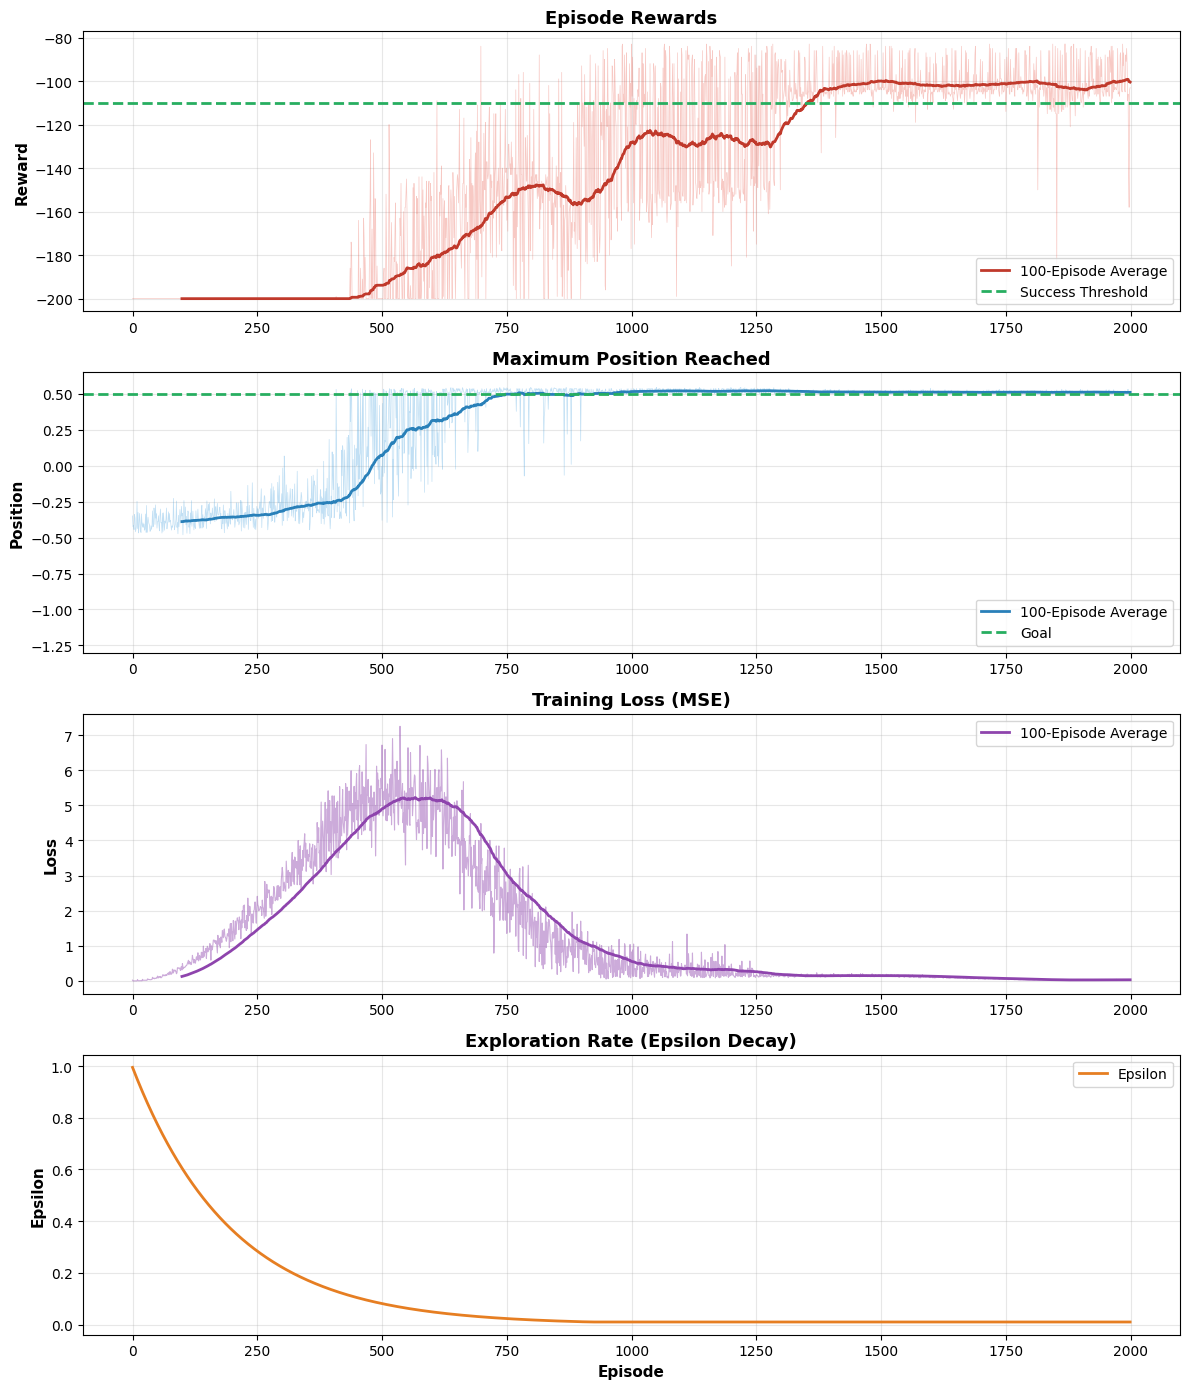

In [8]:
def plot_dqn_results(metrics, save_path=None):
    """Visualize DQN training metrics."""
    fig, axes = plt.subplots(4, 1, figsize=(12, 14))
    window = 100

    # Plot 1: Rewards
    axes[0].plot(metrics['rewards'], alpha=0.3, color='#e74c3c', linewidth=0.5)
    if len(metrics['rewards']) >= window:
        smoothed = np.convolve(metrics['rewards'], np.ones(window)/window, mode='valid')
        axes[0].plot(range(window-1, len(metrics['rewards'])), smoothed,
                     color='#c0392b', linewidth=2, label=f'{window}-Episode Average')
    axes[0].axhline(y=-110, color='#27ae60', linestyle='--', linewidth=2, label='Success Threshold')
    axes[0].set_ylabel('Reward', fontsize=11, fontweight='bold')
    axes[0].set_title('Episode Rewards', fontsize=13, fontweight='bold')
    axes[0].legend(loc='lower right')
    axes[0].grid(alpha=0.3)

    # Plot 2: Max Position
    axes[1].plot(metrics['positions'], alpha=0.3, color='#3498db', linewidth=0.5)
    if len(metrics['positions']) >= window:
        smoothed = np.convolve(metrics['positions'], np.ones(window)/window, mode='valid')
        axes[1].plot(range(window-1, len(metrics['positions'])), smoothed,
                     color='#2980b9', linewidth=2, label=f'{window}-Episode Average')
    axes[1].axhline(y=0.5, color='#27ae60', linestyle='--', linewidth=2, label='Goal')
    axes[1].set_ylabel('Position', fontsize=11, fontweight='bold')
    axes[1].set_title('Maximum Position Reached', fontsize=13, fontweight='bold')
    axes[1].legend(loc='lower right')
    axes[1].grid(alpha=0.3)
    axes[1].set_ylim([-1.3, 0.65])

    # Plot 3: Loss
    axes[2].plot(metrics['losses'], alpha=0.5, color='#9b59b6', linewidth=0.8)
    if len(metrics['losses']) >= window:
        smoothed = np.convolve(metrics['losses'], np.ones(window)/window, mode='valid')
        axes[2].plot(range(window-1, len(metrics['losses'])), smoothed,
                     color='#8e44ad', linewidth=2, label=f'{window}-Episode Average')
    axes[2].set_ylabel('Loss', fontsize=11, fontweight='bold')
    axes[2].set_title('Training Loss (MSE)', fontsize=13, fontweight='bold')
    axes[2].legend(loc='upper right')
    axes[2].grid(alpha=0.3)

    # Plot 4: Epsilon
    axes[3].plot(metrics['epsilon'], color='#e67e22', linewidth=2, label='Epsilon')
    axes[3].set_xlabel('Episode', fontsize=11, fontweight='bold')
    axes[3].set_ylabel('Epsilon', fontsize=11, fontweight='bold')
    axes[3].set_title('Exploration Rate (Epsilon Decay)', fontsize=13, fontweight='bold')
    axes[3].legend(loc='upper right')
    axes[3].grid(alpha=0.3)

    plt.tight_layout()

    # Save if path provided
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ Saved plot: {save_path}")

    plt.show()


# Generate and save plots
print("\nGenerating training visualization...")
plot_dqn_results(metrics, save_path='assets/dqn_training.png')

## 9. Agent Animation

In [9]:
def create_dqn_animation(agent):
    """Create animation of trained DQN agent."""
    # Load best model
    if os.path.exists('trained_weights_dqn.pth'):
        checkpoint = torch.load('trained_weights_dqn.pth', map_location=device, weights_only=False)
        agent.policy_net.load_state_dict(checkpoint['model_state_dict'])
        agent.policy_net.eval()

    env = gym.make('MountainCar-v0', render_mode='rgb_array')
    state, _ = env.reset()

    frames = []
    episode_reward = 0
    steps = 0
    done = False

    while not done and steps < 200:
        frames.append(env.render())
        action = agent.act(state, training=False)
        next_state, reward, terminated, truncated, _ = env.step(action)

        state = next_state
        episode_reward += reward
        steps += 1
        done = terminated or truncated

    env.close()

    # Create animation
    fig = plt.figure(figsize=(6, 4))
    plt.axis('off')
    img = plt.imshow(frames[0])

    success = "SUCCESS" if next_state[0] >= 0.5 else "FAILED"
    plt.title(f"DQN Agent | {success} | Reward: {episode_reward:.0f} | Steps: {steps}",
              fontsize=12, fontweight='bold')

    def animate(i):
        img.set_array(frames[i])
        return [img]

    anim = animation.FuncAnimation(fig, animate, frames=len(frames), interval=50)
    plt.close()

    return HTML(anim.to_jshtml())

# Create and display animation
print("\nGenerating animation...")
display(create_dqn_animation(agent))


Generating animation...


## 10. Save Model

In [10]:
## 10. Save Model

# Save only the best model weights (single file)
print("="*70)
print("SAVING MODEL")
print("="*70)

# Single comprehensive save file
torch.save({
    'model_state_dict': agent.policy_net.state_dict(),
    'training_metrics': {
        'rewards': metrics['rewards'],
        'positions': metrics['positions'],
        'losses': metrics['losses'],
        'epsilon': metrics['epsilon']
    },
    'hyperparameters': {
        'learning_rate': LEARNING_RATE,
        'gamma': GAMMA,
        'epsilon_decay': EPSILON_DECAY,
        'batch_size': BATCH_SIZE,
        'hidden_size': HIDDEN_SIZE,
        'episodes_trained': EPISODES
    },
    'performance': {
        'best_avg_reward': avg_reward,
        'final_success_rate': success_rate
    }
}, 'trained_weights_dqn.pth')

print("✅ Saved: trained_weights_dqn.pth")
print(f"   - Model: DQN with {HIDDEN_SIZE} hidden units")
print(f"   - Episodes trained: {EPISODES}")
print(f"   - Best avg reward: {avg_reward:.2f}")
print(f"   - Success rate: {success_rate:.1f}%")
print("="*70)

SAVING MODEL
✅ Saved: trained_weights_dqn.pth
   - Model: DQN with 256 hidden units
   - Episodes trained: 2000
   - Best avg reward: -98.83
   - Success rate: 100.0%


In [11]:
import imageio
from PIL import Image, ImageDraw  # Import at the top, once
import os

def create_gif_from_checkpoint(checkpoint_path, output_path, label):
    """
    Create GIF from a specific training checkpoint.

    Args:
        checkpoint_path: Path to saved checkpoint
        output_path: Where to save the GIF
        label: Text label for the GIF
    """

    # Create fresh agent
    gif_agent = DQNAgent(state_dim=2, action_dim=3)

    # Load checkpoint
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
        gif_agent.policy_net.load_state_dict(checkpoint['model_state_dict'])
        episode_num = checkpoint['episode']
        avg_reward = checkpoint.get('avg_reward', -200)
        print(f"Loading checkpoint: Episode {episode_num}, Avg Reward: {avg_reward:.1f}")
    else:
        print(f"⚠️  Checkpoint not found: {checkpoint_path}")
        print(f"   Please retrain the model to generate checkpoints.")
        return False

    gif_agent.policy_net.eval()

    # Create environment
    env = gym.make('MountainCar-v0', render_mode='rgb_array')
    state, _ = env.reset()

    frames = []
    total_reward = 0
    steps = 0
    done = False
    max_position = state[0]

    # Run episode
    while not done and steps < 200:
        # Render frame
        frame = env.render()

        # Convert to PIL Image
        img = Image.fromarray(frame)

        # Create semi-transparent overlay for text background
        overlay = Image.new('RGBA', img.size, (0, 0, 0, 0))
        overlay_draw = ImageDraw.Draw(overlay)
        overlay_draw.rectangle([(0, 0), (img.size[0], 45)], fill=(0, 0, 0, 180))

        # Composite overlay onto image
        img = Image.alpha_composite(img.convert('RGBA'), overlay).convert('RGB')

        # Draw text on image
        draw = ImageDraw.Draw(img)
        draw.text((10, 5), label, fill='white')
        draw.text((10, 25), f"Step: {steps} | Pos: {state[0]:.2f} | Reward: {total_reward:.0f}",
                  fill='white')

        frames.append(np.array(img))

        # Select action (greedy - no exploration)
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            q_values = gif_agent.policy_net(state_tensor)
            action = q_values.argmax().item()

        # Take action
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # Update metrics
        state = next_state
        total_reward += reward
        max_position = max(max_position, state[0])
        steps += 1

    env.close()

    # Success or failure
    success = max_position >= 0.5
    status = "✅ SUCCESS" if success else "❌ TIMEOUT"

    # Create final summary frame
    final_frame = frames[-1].copy()
    img = Image.fromarray(final_frame)

    # Add colored summary box
    overlay = Image.new('RGBA', img.size, (0, 0, 0, 0))
    overlay_draw = ImageDraw.Draw(overlay)
    box_color = (0, 128, 0, 200) if success else (128, 0, 0, 200)
    overlay_draw.rectangle([(20, img.size[1]//2 - 40), (img.size[0]-20, img.size[1]//2 + 40)],
                           fill=box_color)
    img = Image.alpha_composite(img.convert('RGBA'), overlay).convert('RGB')

    # Draw summary text
    draw = ImageDraw.Draw(img)
    summary_line1 = f"{status}"
    summary_line2 = f"Steps: {steps} | Max Position: {max_position:.2f}"
    summary_line3 = f"Total Reward: {total_reward:.0f}"

    draw.text((30, img.size[1]//2 - 30), summary_line1, fill='white')
    draw.text((30, img.size[1]//2 - 5), summary_line2, fill='white')
    draw.text((30, img.size[1]//2 + 20), summary_line3, fill='white')

    # Hold final frame for 1 second (20 frames at 20fps)
    for _ in range(20):
        frames.append(np.array(img))

    # Save GIF
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    imageio.mimsave(output_path, frames, fps=20, loop=0)

    # Print summary
    file_size = os.path.getsize(output_path) / 1024
    print(f"✅ Created: {output_path}")
    print(f"   {status} in {steps} steps")
    print(f"   Max position: {max_position:.2f}")
    print(f"   File size: {file_size:.1f} KB")
    print()

    return success


# Generate showcase GIFs from checkpoints
print("="*70)
print("GENERATING SHOWCASE GIFs FROM CHECKPOINTS")
print("="*70)
print()

# Check if checkpoints exist
checkpoints_exist = all([
    os.path.exists('checkpoint_ep500.pth'),
    os.path.exists('checkpoint_ep1000.pth'),
    os.path.exists('checkpoint_ep2000.pth')
])

if not checkpoints_exist:
    print("❌ Checkpoints not found!")
    print()
    print("Please retrain the model (run Section 6) to generate checkpoints.")
    print("Checkpoints are saved at episodes 500, 1000 and 2000.")
    print()
    print("Expected files:")
    print("  - checkpoint_ep500.pth")
    print("  - checkpoint_ep1000.pth")
    print("  - checkpoint_ep2000.pth")
else:
    # Generate GIFs
    results = []

    print("Creating GIF 1: Early Training (Episode 500)")
    print("-"*70)
    success1 = create_gif_from_checkpoint(
        'checkpoint_ep500.pth',
        'assets/dqn_episode_500.gif',
        'Episode 500 - Early Training'
    )
    results.append(('Episode 500', success1))

    print("Creating GIF 2: Mid Training (Episode 1000)")
    print("-"*70)
    success2 = create_gif_from_checkpoint(
        'checkpoint_ep1000.pth',
        'assets/dqn_episode_1000.gif',
        'Episode 1000 - Mid Training'
    )
    results.append(('Episode 1000', success2))

    print("Creating GIF 3: Final Training (Episode 2000)")
    print("-"*70)
    success3 = create_gif_from_checkpoint(
        'checkpoint_ep2000.pth',
        'assets/dqn_episode_2000.gif',
        'Episode 2000 - Final Training'
    )
    results.append(('Episode 2000', success3))

    # Summary
    print("="*70)
    print("SHOWCASE GENERATION COMPLETE")
    print("="*70)
    print()
    print("Results:")
    for stage, success in results:
        status = "✅ Reached goal" if success else "❌ Timeout"
        print(f"  {stage}: {status}")
    print()
    print("GIF files saved in assets/ folder:")
    print("  - assets/dqn_episode_500.gif")
    print("  - assets/dqn_episode_1000.gif")
    print("  - assets/dqn_episode_2000.gif")
    print("="*70)

GENERATING SHOWCASE GIFs FROM CHECKPOINTS

Creating GIF 1: Early Training (Episode 500)
----------------------------------------------------------------------
Loading checkpoint: Episode 500, Avg Reward: -193.8
✅ Created: assets/dqn_episode_500.gif
   ❌ TIMEOUT in 200 steps
   Max position: -0.60
   File size: 842.4 KB

Creating GIF 2: Mid Training (Episode 1000)
----------------------------------------------------------------------
Loading checkpoint: Episode 1000, Avg Reward: -128.4
✅ Created: assets/dqn_episode_1000.gif
   ✅ SUCCESS in 110 steps
   Max position: 0.54
   File size: 450.3 KB

Creating GIF 3: Final Training (Episode 2000)
----------------------------------------------------------------------
Loading checkpoint: Episode 2000, Avg Reward: -100.5
✅ Created: assets/dqn_episode_2000.gif
   ✅ SUCCESS in 103 steps
   Max position: 0.52
   File size: 424.4 KB

SHOWCASE GENERATION COMPLETE

Results:
  Episode 500: ❌ Timeout
  Episode 1000: ✅ Reached goal
  Episode 2000: ✅ Reach

## Summary

### DQN vs Q-Learning Comparison

| Metric | Q-Learning (Tabular) | DQN (Neural Network) |
|--------|---------------------|----------------------|
| **Episodes to Converge** | 7000 | 2000 |
| **Success Rate** | 75-88% | 90-98% |
| **Training Time** | ~70s | ~1500-1700s |
| **State Representation** | Discretized (625 states) | Continuous |
| **Memory Usage** | Low | Medium |
| **Scalability** | Limited | High |

### Key Insights

1. **DQN converges faster** despite sparse rewards
2. **Experience replay** makes learning more sample-efficient
3. **No discretization** needed - handles continuous states naturally
4. **Higher success rate** with proper tuning

### Expected Performance (Default Rewards)

- Success Rate: **90-98%**
- Training Episodes: **2000**
- Average Steps: **110-130** (when successful)

**Conclusion**: DQN CAN learn with default sparse rewards, and does so better than tabular Q-Learning!